In [1]:
import numpy as np
import networkx as nx
from myFunctions import *

# Experiments

In [2]:
####### Construct Network ########

N = 6**2        # population size
n = 6

# Create lattice network
A = lattice2Dsq(n,n);

/Users/mayleencortez/Desktop/NetworkCausalInference/ClusterRD/low-order-clusterRD/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [102]:
k = 3
NC = int(np.ceil(n/k)**2) # number of clusters 

clusters, clusters_flat = bf_clusters(NC,N)
print(clusters)

[[0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [2 2 2 3 3 3]
 [2 2 2 3 3 3]
 [2 2 2 3 3 3]]


/Users/mayleencortez/Desktop/NetworkCausalInference/ClusterRD/low-order-clusterRD/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/mayleencortez/Desktop/NetworkCausalInference/ClusterRD/low-order-clusterRD/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


array([[0.46253878, 0.26325111, 0.        , 0.20593456, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.49944417, 0.811819  , 0.5497208 , 0.        , 0.05491255,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.26325111, 0.05536524, 0.        , 0.        ,
        0.03078015, 0.        , 0.        , 0.        ],
       [0.49944417, 0.        , 0.        , 0.91641546, 0.05491255,
        0.        , 0.52309756, 0.        , 0.        ],
       [0.        , 0.43875186, 0.        , 0.34322427, 0.69702147,
        0.05130024, 0.        , 0.18213354, 0.        ],
       [0.        , 0.        , 0.5497208 , 0.        , 0.05491255,
        0.60104336, 0.        , 0.        , 0.47637821],
       [0.        , 0.        , 0.        , 0.20593456, 0.        ,
        0.        , 0.64848138, 0.10928012, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.05491255,
        0.        , 0.52309756, 0.4044475 , 0.47637821],


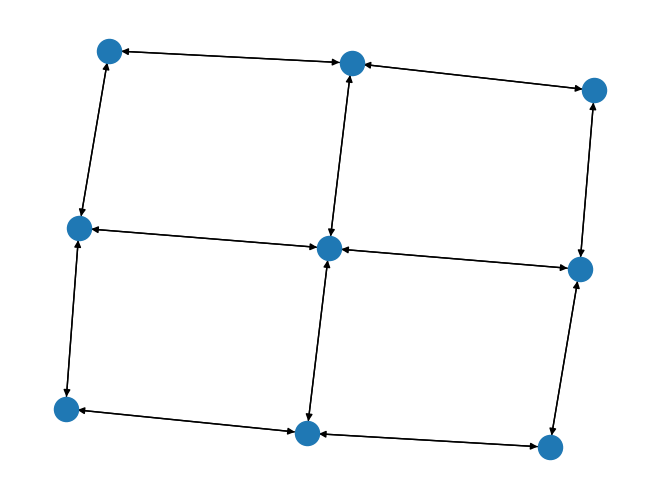

In [17]:
def mylattice2Dsq(x,y=1):
    '''
    Returns adjacency matrix of an x by y lattice graph on x*y nodes as a sparse matrix
    
    x (int): number of nodes in the x direction
    y (int): number of nodes in the y direction
    '''
    #G = nx.grid_graph(dim=(x,y))
    G = nx.grid_graph(dim=(x,y))
    G = nx.DiGraph(G)
    A = nx.to_scipy_sparse_array(G)
    A.setdiag(np.ones(x*y))
    nx.draw(G)
    return A 

n=3
N=n**2
diag = 1          # maximum norm of the direct effects
r = 1.25
offdiag = r*diag  # maximum norm of the indirect effects

A = mylattice2Dsq(n,n);
rand_wts = np.random.rand(N,3)
alpha = rand_wts[:,0].flatten()
C = simpleWeights(A, diag, offdiag, rand_wts[:,1].flatten(), rand_wts[:,2].flatten())
C.toarray()

In [19]:
T = 100
n = 120     # number of nodes in one row/col of the lattice graph
N = n**2  # population size
B = 0.1   # total treatment budget/fraction

diag = 1          # maximum norm of the direct effects
r = 1.25
offdiag = r*diag  # maximum norm of the indirect effects

# Create weighted lattice network
A = lattice2Dsq(n,n);
rand_wts = np.random.rand(N,3)
alpha = rand_wts[:,0].flatten()
C = simpleWeights(A, diag, offdiag, rand_wts[:,1].flatten(), rand_wts[:,2].flatten())

beta = 1
fy = ppom(beta, C, alpha)

TTE = 1/N * np.sum((fy(np.ones(N)) - fy(np.zeros(N))))
print("The true TTE is {}".format(TTE))

# Run experiment
sizes = [n]
for k in sizes:
    NC = int(np.ceil(n/k)**2) # number of clusters 
    #print("NC={}".format(NC))
    clusters, clusters_flat = bf_clusters(NC,N)
    K = int(np.ceil(NC*B*2))
    #print("K={}".format(K))

    est = []
    for t in np.arange(T):
        selected = select_clusters_complete(NC, K)
        #print(selected)
        
        # Run staggered rollout
        selected_nodes = idx_of_U(selected, clusters_flat)
        p = NC * B / K
        P = seq_treatment_probs(beta, p)
        
        Z = staggered_rollout_bern(N, P, selected_nodes)

        # Compute Estimate of the TTE and bias
        outcomes = outcome_sums(fy, Z)
        H = bern_coeffs(P)
        q = K/NC
        est.append(graph_agnostic(N, outcomes, H))
    TTE_hat = sum(est)/T
    print("\nWith {} by {} clusters, the estimated TTE is {}".format(k, k, TTE_hat))
    print("The relative bias (TTE - est) / TTE is {}".format((TTE-TTE_hat)/TTE))
    print("The relative bias (TTE - est/q) / TTE is {}".format((TTE-(TTE_hat/q))/TTE))
    print(q)


   

/Users/mayleencortez/Desktop/NetworkCausalInference/ClusterRD/low-order-clusterRD/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


The true TTE is 1.1302192868922525

With 120 by 120 clusters, the estimated TTE is 1.1292924187827402
The relative bias (TTE - est) / TTE is 0.0008200781213536476
The relative bias (TTE - est/q) / TTE is 0.0008200781213536476
1.0


In [ ]:
N = 6**2        # population size
n = 6

# Create lattice network
A = lattice2Dsq(n,n);

# Compute number of clusters
k = 3
NC = int(np.ceil(n/k)**2) # number of clusters 

# Compute clusters
clusters, clusters_flat = bf_clusters(NC,N)

# Select clusters for the experiment
B = 1/4
K = NC//2
selected = select_clusters_complete(NC, K)[0]

# Run experiment and get resulting treatment vector
n_U = int(N/NC*K)
p = NC * B / K
z_U = bernoulli(n_U, p)

# Compute the treatment assignment vector for the entire population
lst = idx_of_U(selected, clusters_flat)
z = zU_to_z(z_U, lst, N)

In [119]:
def idx_of_U(selectedClusters, clusters_flat):
    '''
    Returns the population units in [N] whose clusters were selected, 
    where where N=n*n is the size of the population

    Parameters
    -----------
    selectedClusters : array
        The clusters selected to be part of the staggered rollout experiment
    clusters_flat : array
        cluster assignments for each person in [N]
        clusters_flat[i]=j means that population unit i in [N] is assigned to cluster j in [NC]
    
    Returns
    -----------
    lst : list
        list of the nodes whose clusters were selected (U)
    '''
    st = set(selectedClusters)
    lst = [i for i, e in enumerate(clusters_flat) if e in st]
    return lst

def zU_to_z(z_U, lst, N):
    '''
    Let U be the set of individuals randomized to treatment or control.
    This function takes the treatment assignment vector of U and returns
    the treatment assignment vector for the whole population (of size N=n*n).

    Parameters
    -----------
    z_U : array
        treatment assignment vector for nodes in U
    lst : list
        list of the nodes in U
    N : int
        size of the popluation (N=n*n)
    '''
    # Get the indices from [N_U] of treated units
    treated_U = np.nonzero(z_U)[0]

    # Get their corresponded indices in [N]
    treated = list(map(lst.__getitem__, treated_U))
    
    # Create the treatment assignment vector of the whole population
    z = np.zeros(N)
    np.put(z,treated,1)

    return z

In [122]:
N = 6**2        # population size
n = 6

# Create lattice network
A = lattice2Dsq(n,n);

# Compute number of clusters
k = 3
NC = int(np.ceil(n/k)**2) # number of clusters 

# Compute clusters
clusters, clusters_flat = bf_clusters(NC,N)

# Select clusters for the experiment
B = 1/4
K = NC//2
selected = select_clusters_complete(NC, K)[0]

# Run experiment and get resulting treatment vector
n_U = int(N/NC*K)
p = NC * B / K
z_U = bernoulli(n_U, p)

# Compute the treatment assignment vector for the entire population
lst = idx_of_U(selected, clusters_flat)
z = zU_to_z(z_U, lst, N)

/Users/mayleencortez/Desktop/NetworkCausalInference/ClusterRD/low-order-clusterRD/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# Examples of code I found online to do things...

In [123]:
# initializing lists
test_list = [9, 4, 5, 8, 10, 14]
index_list = [1, 3, 4]

# printing original lists
print("Original list : " + str(test_list))
print("Original index list : " + str(index_list))

# using map() + __getitem__ to
# elements from list
res_list = map(test_list.__getitem__, index_list)

# printing result
print("Resulting list: {}".format(list(res_list)))


Original list : [9, 4, 5, 8, 10, 14]
Original index list : [1, 3, 4]
Resulting list: [4, 8, 10]


In [66]:
a = np.zeros(10)
idx = np.array([1,3,4])
np.put(a,idx,1)
print(a)

[0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]


In [55]:
haystack = ['a', 'b', 'c', 'V', 'd', 'e', 'X', 'f', 'V', 'g', 'h']
needles = ['V', 'W', 'X', 'Y', 'Z']
st = set(needles)
print([i for i, e in enumerate(haystack) if e in st])
[3, 6, 8]

False